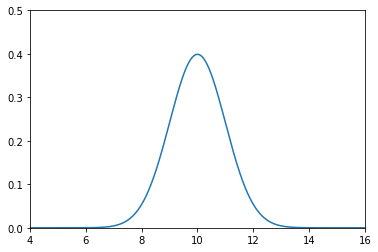

In [1]:
import filterpy.stats as stats
stats.plot_gaussian_pdf(mean=10.,variance=1.,xlim=(4,16),ylim=(0.,.5));

mean of readings is 9.993


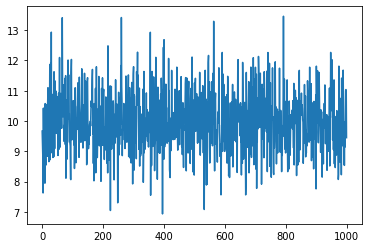

In [6]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt

xs = range(1000)
ys = randn(1000)*1. + 10.
plt.plot(xs, ys)
print(f'mean of readings is {np.mean(ys):.3f}')

In [37]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: f'N(mean={s[0]}, variance={s[1]})'

In [38]:
g1 = gaussian(3.4,10.1)
g2 = gaussian(mean=4.5, var=0.2**2)
print(g1)
print(g2)

N(mean=3.4, variance=10.1)
N(mean=4.5, variance=0.04000000000000001)


In [9]:
def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

# test the update function
predicted_pos = gaussian(10., .2**2)
measured_pos = gaussian(11., .1**2)
estimated_pos = update(predicted_pos, measured_pos)
estimated_pos

N(mean=10.799999999999999, variance=0.008000000000000002

## Gaussian Multiplication Demo

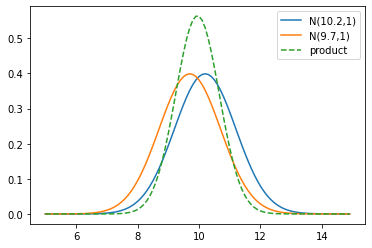

In [19]:
def plot_gaussian_multiply(z1, z2):
    # z1 = gaussian(10., 1.) # gaussian N(10,1)
    # z2 = gaussian(5.,2.) # gaussian N(5,2)

    product = gaussian_multiply(z1,z2)

    xs = np.arange(5, 15, 0.1)
    ys = [stats.gaussian(x, z1.mean, z1.var) for x in xs]
    plt.plot(xs, ys, label=f'N({z1.mean},{z1.var})')

    ys = [stats.gaussian(x, z2.mean, z2.var) for x in xs]
    plt.plot(xs, ys, label=f'N({z2.mean},{z2.var})')

    ys = [stats.gaussian(x, product.mean, product.var) for x in xs]
    plt.plot(xs, ys, label=f'product', ls='--')
    plt.legend()

z1 = gaussian(10.2, 1)
z2 = gaussian(9.7, 1)
plot_gaussian_multiply(z1,z2)

In [20]:
from ipywidgets import interact

def interactive_gaussian(m1, m2, v1, v2):
    g1 = gaussian(m1, v1)
    g2 = gaussian(m2, v2)
    plot_gaussian_multiply(g1, g2)
    
interact(interactive_gaussian,
         m1=(5, 10., .5), m2=(10, 15, .5), 
         v1=(.1, 2, .1), v2=(.1, 2, .1));

interactive(children=(FloatSlider(value=7.5, description='m1', max=10.0, min=5.0, step=0.5), FloatSlider(value…

## Kalman Filter Implementation

In [22]:
import numpy as np
from numpy import sqrt
class DogSimulation(object):
    def __init__(self, x0=0, velocity=1,
                 measurement_var=0.0,
                 process_var=0.0):
        """ x0 : initial position
            velocity: (+=right, -=left)
            measurement_var: variance in measurement m^2
            process_var: variance in process (m/s)^2
        """
        self.x = x0
        self.velocity = velocity
        self.meas_std = sqrt(measurement_var)
        self.process_std = sqrt(process_var)

    def move(self, dt=1.0):
        """Compute new position of the dog in dt seconds."""
        dx = self.velocity + randn()*self.process_std    # this variance should be different from process model variance, dx is real measured value
        self.x += dx * dt

    def sense_position(self):
        """ Returns measurement of new position in meters."""
        measurement = self.x + randn()*self.meas_std
        return measurement

    def move_and_sense(self):
        """ Move dog, and return measurement of new position in meters"""
        self.move()
        return self.sense_position()

In [23]:
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

In [24]:
process_var = 1. # variance in the dog's movement
sensor_var = 2. # variance in the sensor

x = gaussian(0., 20.**2)  # dog's position, N(0, 20**2)
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity*dt, process_var) # displacement to add to x
  
# simulate dog and get measurements
dog = DogSimulation(
    x0=x.mean, 
    velocity=process_model.mean, 
    measurement_var=sensor_var, 
    process_var=process_model.var)

# create list of measurements
zs = [dog.move_and_sense() for _ in range(10)]

In [25]:
print('PREDICT\t\t\tUPDATE')
print('     x      var\t\t  z\t    x      var')

# perform Kalman filter on measurement z
for z in zs:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    # kf_internal.print_gh(prior, x, z)

print()
print('final estimate:        {:10.3f}'.format(x.mean))
print('actual final position: {:10.3f}'.format(dog.x))

PREDICT			UPDATE
     x      var		  z	    x      var

final estimate:             7.992
actual final position:      5.144


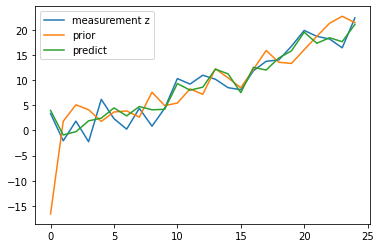

In [53]:
process_var = 2.  # Qk, untracked influence to the model
sensor_var = 4.5
x = gaussian(0., 400.)
process_model = gaussian(1., process_var)  # velocity*dt, process var
N = 25

dog = DogSimulation(x.mean, process_model.mean, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]

xs, priors = np.zeros((N, 2)), np.zeros((N, 2))
for i, z in enumerate(zs):
    prior = predict(x, process_model)    #Xk_predict, Pk
    x = update(prior, gaussian(z, sensor_var)) # N(Xk_predict,Pk) * N(Zk,Rk) 
    priors[i] = prior
    
    xs[i] = x

# xs = np.arange(5, 15, 0.1)
#     ys = [stats.gaussian(x, z1.mean, z1.var) for x in xs]
#     plt.plot(xs, ys, label=f'N({z1.mean},{z1.var})')

#     ys = [stats.gaussian(x, z2.mean, z2.var) for x in xs]
#     plt.plot(xs, ys, label=f'N({z2.mean},{z2.var})')

#     ys = [stats.gaussian(x, product.mean, product.var) for x in xs]
#     plt.plot(xs, ys, label=f'product', ls='--')
#     plt.legend()
# print(f'zs is: {zs}. {len(zs)}')

x_frame = np.arange(0,25,1)
y_measure = [zs[i] for i in range(N)]
plt.plot(x_frame, y_measure, label=f'measurement z')
# plt.legend()

# print(priors)
# print(type(priors[0]))
# print(priors[0].shape)

y_prior = [np.random.normal(priors[i,0],sqrt(priors[i,1])) for i in range(N)]
plt.plot(x_frame, y_prior, label=f'prior')

y_predict = [np.random.normal(xs[i,0],sqrt(xs[i,1])) for i in range(N)]
plt.plot(x_frame, y_predict, label=f'predict')
plt.legend()